# Classifier is much faster with PCA, however it's accuracy 12%
# Without PCA, accuracy ~ 55%

In [114]:
import pandas as pd
import numpy as np
from math import *
import matplotlib.pyplot as plt
import csv
from PIL import Image 
import itertools
from sklearn.model_selection import train_test_split
from scipy.special import expit
%matplotlib inline
from sklearn import preprocessing
import scipy
from sklearn.decomposition import PCA

In [115]:
data = pd.read_csv("mnist_train.csv") # First column = labels. Rest are pixels
data = data.to_numpy()
y = data[:, 0]
# normalize those columns so we don't have RuntimeWarning: overflow encountered in exp
X = data[:, 1:]
# sum_cols = X.sum(axis=0)
# indice = np.nonzero(sum_cols != 0)
# indice = list(itertools.chain(*indice))
X = X.astype('float64')
# X[:, indice] = (X[:, indice] - X[:, indice].mean(axis=0)) \
#                            / (X[:, indice].max(axis=0) - X[:, indice].min(axis=0))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train = X_train / 255
X_test = X_test / 255
y_train = np.reshape(y_train, (len(y_train),1))
y_test = np.reshape(y_test, (len(y_test),1))

In [116]:
X_train.shape

(42000, 784)

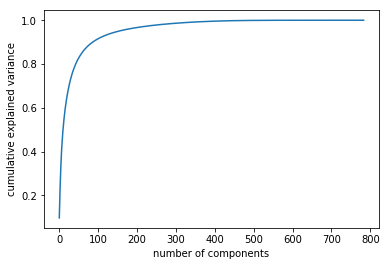

In [117]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [118]:
for k in range(200, 500):
    S = pca.explained_variance_ratio_
    if sum(S[:k]) / sum(S) >= 0.99:
        K = k # reduced num of features
        print(k)
        break

331


In [119]:
pca = PCA(n_components=K)

X_combined = np.concatenate([X_train, X_test])
X_combined = pca.fit_transform(X_combined)
X_train_reduced = X_combined[:42000, :]
X_test_reduced = X_combined[42000:, :]

In [120]:
def sigmoid(z):
    z = np.ones(z.shape) / (1 + np.exp(-z))
    return z

# return cost function and partial derivatives for gradient
def nn(nn_params, X, y):
    input_layer_size = 331 # 28x28 Input Images of Digits # reduced features
    hidden_layer_size = 300   # 49 hidden units (1/16 the size of input layer)
    num_labels = 10                 # 10 labels, from 1 to 10 (note that we mapped "0" to label 10)
    reg_lambda = 0
    ones = np.reshape(np.ones(len(X)), (len(X), 1))
    X = np.concatenate((ones, X), axis=1)

    # Reshape nn_params back into the parameters Theta1 and Theta2, the weight matrices
    # for our 2 layer neural network
    Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                     (hidden_layer_size, (input_layer_size + 1)))
    Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                     (num_labels, (hidden_layer_size + 1)))

    m = len(X) 
    Theta1_grad = np.zeros(Theta1.shape) 
    Theta2_grad = np.zeros(Theta2.shape) 

    eye_matrix = np.eye(num_labels) 
    y = np.ravel(y)
    y_matrix = eye_matrix[y,:]  # 5000 x 10 # y must be 1-D array
    
    a1 = X  # (5000, 785)
    z2 = a1 @ Theta1.T  # (5000, 785) * (785, 49) => 5000 x 49
    a2 = sigmoid(z2)  # 5000 x 49
    a2 = np.hstack((np.ones((len(X), 1)), a2)) # 5000 x 50
    z3 = a2 @ Theta2.T # 5000 x 50 * 50 x 10
    a3 = sigmoid(z3)   # 5000 x 10
    
    pre_allocated = np.empty_like(a3)
    d3 = np.subtract(a3, y_matrix, out=pre_allocated)
    d2 = d3 @ Theta2[:, 1:] * sigmoid(z2)  # 5000 x 10 * 10 x 49 => 5000 x 49
   
    Theta1_grad = 1/m * (Theta1_grad + d2.T @ a1)  # 49 x 5000 * 5000 x 785 => (49, 785)
    Theta2_grad = 1/m * (Theta2_grad + d3.T @ a2)  # 10 x 5000 * 5000 x 50  => (10, 50)   
    
    Theta1_grad[:, 1:] = Theta1_grad[:, 1:] + 1/m * (reg_lambda * Theta1[:, 1:])  
    Theta2_grad[:, 1:] = Theta2_grad[:, 1:] + 1/m * (reg_lambda * Theta2[:, 1:])    

    term1 = expit(np.log(a3))
    term2 = expit(np.log(1 - a3))
    
    J = -1/m * (sum(sum(y_matrix * term1 + (1 - y_matrix) * term2)))
    + reg_lambda/(2*m) * (sum(sum(Theta1[:, 1:] ** 2)) + sum(sum(Theta2[:, 1:] ** 2))) 

    grad = np.concatenate((np.ravel(Theta1_grad), np.ravel(Theta2_grad))) # Unroll gradients
    return J, grad

def CostFunc(nn_params, X, y):
    J = nn(nn_params, X, y)[0]
    return J
def Gradient(nn_params, X, y):
    grad = nn(nn_params, X, y)[1]
    return grad

In [122]:
Theta1 = np.random.uniform(size=(300, 332)) # size([# hidden units], [# input units + 1])
Theta2 = np.random.uniform(size=(10, 301))  # size([# output units], [# hidden units + 1])
nn_params = np.concatenate((np.ravel(Theta1), np.ravel(Theta2)))
Trial = Gradient(nn_params, X_train_reduced, y_train)
Trial.shape

/Users/eloisezeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


(102610,)

In [124]:
import scipy.optimize as op

input_layer_size  = 331  # 28x28 Input Images of Digits
hidden_layer_size = 300   # 49 hidden units (1/16 the size of input layer)
num_labels = 10          # 10 labels, from 1 to 10 (note that we mapped "0" to label 10)
 
Theta1 = np.random.uniform(size=(300, 332)) # size([# hidden units], [# input units + 1])
Theta2 = np.random.uniform(size=(10, 301))  # size([# output units], [# hidden units + 1])
nn_params = np.concatenate((np.ravel(Theta1), np.ravel(Theta2)))

Result = op.minimize(fun = CostFunc, 
                    x0 = nn_params, 
                    args = (X_train_reduced, y_train),
                    jac = Gradient, method='TNC') 

nn_params = Result.x # optimal theta
Result

/Users/eloisezeng/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: divide by zero encountered in log


     fun: -0.5490654911327446
     jac: array([1.93102553, 0.96538226, 0.40983748, ..., 0.46616603, 0.50149863,
       0.48009527])
 message: 'Converged (|f_n-f_(n-1)| ~= 0)'
    nfev: 51
     nit: 1
  status: 1
 success: True
       x: array([0.94498323, 0.69796635, 0.36063899, ..., 0.34222626, 0.50800316,
       0.32749135])

In [125]:
Theta1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                     (hidden_layer_size, (input_layer_size + 1)))
Theta2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                     (num_labels, (hidden_layer_size + 1)))

In [126]:
def predict(Theta1, Theta2, X):
    m = len(X)
    num_labels = Theta2.shape[0]
    
    X = np.hstack((np.ones((len(X), 1)), X)) # (42000, 332)
    print(X.shape)
    h1 = sigmoid(X @ Theta1.T) # (42000, 332) * (332, 300)
    print(h1.shape)
    h1 = np.hstack((np.ones((len(X), 1)), h1)) # (42000, 101)
    h2 = sigmoid(h1 @ Theta2.T) # (42000, 101) * 101 x 10
    print(h2.shape)
    p = np.argmax(h2, axis=1)
    print(p.shape)
    return p

In [127]:
predict(Theta1, Theta2, X_train_reduced)[:100]

(42000, 332)
(42000, 300)
(42000, 10)
(42000,)


array([0, 0, 5, 5, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 2, 6,
       0, 0, 0, 0, 7, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 0, 5, 0,
       0, 0, 0, 2, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 7, 0, 0, 0, 2, 0, 0, 2,
       0, 0, 9, 0, 4, 0, 0, 0, 2, 8, 2, 8, 0, 0, 2, 0, 0, 0, 0, 8, 0, 0,
       0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0])

In [128]:
accuracy = sum(predict(Theta1, Theta2, X_train_reduced) == np.ravel(y_train)) / len(X_train_reduced)
print(str(round(accuracy * 100, 3)) + " %")

(42000, 332)
(42000, 300)
(42000, 10)
(42000,)
12.152 %


In [129]:
accuracy = sum(predict(Theta1, Theta2, X_test_reduced) == np.ravel(y_test)) / len(X_test_reduced)
print(str(round(accuracy * 100, 3)) + " %")

(18000, 332)
(18000, 300)
(18000, 10)
(18000,)
12.122 %
